In [26]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import keras as ks
from keras.preprocessing import image as kimage
import skimage.io as io
import random
import sys
import pickle as pkl
from imblearn.keras import BalancedBatchGenerator
from keras.utils import np_utils
lib_path = os.path.join(os.path.realpath(r"C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\DataAugmentationForObjectDetection-master"), "data_aug")
sys.path.append(lib_path)
from bbox_util import *
from data_aug import *
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from keras.layers import Concatenate,Input, Dense, Flatten, Reshape, MaxPooling2D, Conv2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, explained_variance_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import skimage.measure

## Import dei dati

In [56]:
X_test = np.load('array_da_importare/X_test_speriamo_bene.npy')
y_test = np.load('array_da_importare/y_test_speriamo_bene.npy')
X_1 = np.load('array_da_importare/train_speriamo_bene_completo_X.npy')
y_1 = np.load('array_da_importare/train_speriamo_bene_completo_Y.npy')

## Preprocessing

In [57]:
opt = ks.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.99)
opt2 = SGD(lr=0.1, momentum=0.9, nesterov=True, decay=0.001) # lr = 0.01, decay=0.0001
opt3 = ks.optimizers.RMSprop(lr=0.001, rho=0.9)
opt4 = ks.optimizers.Adagrad(lr=0.01)
opt5 = ks.optimizers.Adadelta(lr= 1.0, rho=0.95)
opt6 = ks.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
opt7 = ks.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999)

## Modello1 - C'è il segnale?

## Preprocessing

In [58]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_1, y_1, test_size=0.2, stratify = y_1)
X_train1 = X_train1/255
X_val1 = X_val1/255
X_test = X_test/255

## Creazione del modello 

In [59]:
def balanced_flow_from_directory(flow_from_directory):
    for immagini, classi in flow_from_directory:
         yield custom_balance(immagini, classi)
            
def custom_balance(immagini, classi):
    rus = RandomUnderSampler()
    X_resampled, y_resampled = rus.fit_sample(immagini.reshape(immagini.shape[0], immagini.shape[1]*immagini.shape[2]*immagini.shape[3]), classi)     
    X_resampled = X_resampled.reshape(X_resampled.shape[0], immagini.shape[1], immagini.shape[2], immagini.shape[3])
    X_resampled, y_resampled = shuffle(X_resampled, y_resampled)
    y_resampled = y_resampled.reshape(y_resampled.shape[0], 1, 1, 1) #da mettere se uso model_conv()
    #y_resampled = np_utils.to_categorical(y_resampled, 2) #da mettere se uso model_flat()
    return(X_resampled, y_resampled)

In [60]:
train_processing_flow = kimage.ImageDataGenerator()
train_generator_flow = train_processing_flow.flow((X_train1, y_train1), 
                    batch_size=200,
                    shuffle=True #riordino i dati in maniera casuale
                    )      
train_generator_bal = balanced_flow_from_directory(train_generator_flow)

val_processing_flow = kimage.ImageDataGenerator()
val_generator_flow = val_processing_flow.flow((X_val1, y_val1), 
                    batch_size=200,
                    shuffle=True #riordino i dati in maniera casuale
                    )      
val_generator_bal = balanced_flow_from_directory(val_generator_flow)

In [61]:
from keras.callbacks import History 
def model_conv():
    model = Sequential()

    model.add(Conv2D(filters=8, kernel_size=7, strides=1, input_shape=(None,None,3))) #(None,None,3)
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    #model.add(Dropout(0.5))

    model.add(Conv2D(filters=16, kernel_size=9, strides=1))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=2, strides=2)) #stride 2

    #model.add(Dropout(0.5))

    model.add(Conv2D(filters=32, kernel_size=9, strides=1))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    #model.add(Dropout(0.5))

    model.add(Conv2D(filters = 64, kernel_size=5, strides=1))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(Conv2D(filters = 1, kernel_size=1, strides=1))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    #model.add(MaxPooling2D(pool_size=1, strides=2))
    #model.add(GlobalAveragePooling2D())

    model.add(Activation('sigmoid'))
    return model

    #model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [62]:
model = model_conv()

In [ ]:
#model.save('models/is_signal.h5')

In [ ]:
#is_signal_model = is_signal_model(opt2)
#model.compile(loss='binary_crossentropy', optimizer=opt2, metrics=['accuracy'])

In [63]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [64]:
#model.fit_generator(generator=train_generator_bal, epochs=100, verbose=1, callbacks=[history], validation_data = val_generator_bal, validation_steps=200, steps_per_epoch= 200)  #allenato in 120 epoche  

Epoch 1/100
200/200 [==============================] - 16s 79ms/step - loss: 0.3580 - acc: 0.9242 - val_loss: 0.2515 - val_acc: 0.9457
Epoch 2/100
200/200 [==============================] - 7s 34ms/step - loss: 0.2709 - acc: 0.9723 - val_loss: 0.2294 - val_acc: 0.9701
Epoch 3/100
200/200 [==============================] - 6s 32ms/step - loss: 0.2281 - acc: 0.9795 - val_loss: 0.2551 - val_acc: 0.9366
Epoch 4/100
200/200 [==============================] - 7s 35ms/step - loss: 0.1938 - acc: 0.9832 - val_loss: 0.1659 - val_acc: 0.9794
Epoch 5/100
200/200 [==============================] - 7s 34ms/step - loss: 0.1653 - acc: 0.9862 - val_loss: 0.1462 - val_acc: 0.9844
Epoch 6/100
200/200 [==============================] - 7s 34ms/step - loss: 0.1395 - acc: 0.9895 - val_loss: 0.2053 - val_acc: 0.9346
Epoch 7/100
200/200 [==============================] - 7s 36ms/step - loss: 0.1215 - acc: 0.9896 - val_loss: 0.1251 - val_acc: 0.9739
Epoch 8/100
200/200 [==============================] - 7s 36m

Epoch 62/100
200/200 [==============================] - 7s 36ms/step - loss: 0.0041 - acc: 0.9986 - val_loss: 0.0063 - val_acc: 0.9981
Epoch 63/100
200/200 [==============================] - 7s 34ms/step - loss: 0.0039 - acc: 0.9985 - val_loss: 0.0073 - val_acc: 0.9975
Epoch 64/100
200/200 [==============================] - 7s 34ms/step - loss: 0.0051 - acc: 0.9985 - val_loss: 0.0092 - val_acc: 0.9971
Epoch 65/100
200/200 [==============================] - 7s 36ms/step - loss: 0.0021 - acc: 0.9992 - val_loss: 0.0066 - val_acc: 0.9980
Epoch 66/100
200/200 [==============================] - 7s 36ms/step - loss: 0.0028 - acc: 0.9990 - val_loss: 0.0107 - val_acc: 0.9963
Epoch 67/100
200/200 [==============================] - 7s 35ms/step - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0278 - val_acc: 0.9920
Epoch 68/100
200/200 [==============================] - 7s 35ms/step - loss: 0.0044 - acc: 0.9985 - val_loss: 0.0459 - val_acc: 0.9887
Epoch 69/100
200/200 [==============================] -

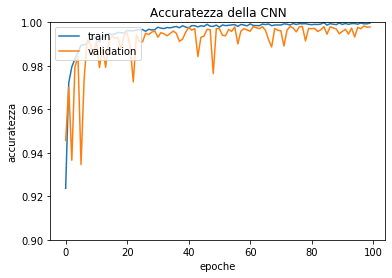

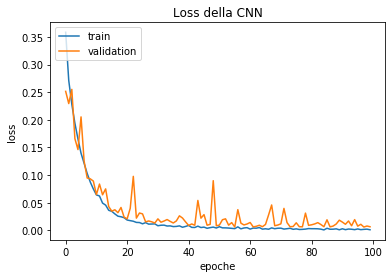

In [72]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuratezza della CNN')
plt.ylabel('accuratezza')
plt.xlabel('epoche')
plt.legend(['train', 'validation'], loc='upper left')
plt.gca().set_ylim([0.90,1])
plt.savefig('Report/cnn_accuracy.png')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss della CNN')
plt.ylabel('loss')
plt.xlabel('epoche')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Report/cnn_loss.png')
plt.show()

In [73]:
#model.load_weights('weights/model_is_signal_conv.hdf5')

# Metriche in train e test

In [74]:
preds = model.predict(X_test)

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, np.round(preds.reshape(preds.shape[0])))

0.9985362283483776

In [15]:
cr = classification_report(y_test, np.round(preds.reshape(preds.shape[0])))
print(cr)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20162
         1.0       1.00      1.00      1.00     12630

    accuracy                           1.00     32792
   macro avg       1.00      1.00      1.00     32792
weighted avg       1.00      1.00      1.00     32792



In [76]:
preds = model.predict(X_train1)
cr = classification_report(y_train1, np.round(preds.reshape(preds.shape[0])))
print(cr)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    105879
         1.0       1.00      1.00      1.00     62734

    accuracy                           1.00    168613
   macro avg       1.00      1.00      1.00    168613
weighted avg       1.00      1.00      1.00    168613



In [77]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train1, np.round(preds.reshape(preds.shape[0])))

0.9992408651764692

In [17]:
confusion_matrix(y_train1, np.round(preds.reshape(preds.shape[0])))

array([[132305,     44],
       [   131,  78287]], dtype=int64)